In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from torch.optim import SGD
import torch
from torch.utils.tensorboard import SummaryWriter
import os
import time
import gpytorch
import argparse


/home/diegog/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
ds = load_dataset("wikipedia", "20220301.simple")
model_name = 'gpt2'

In [3]:
subsample_size = int(0.0001 * len(ds['train']))

In [5]:
subsample = ds['train'].shuffle(seed=42).select(range(subsample_size))

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)


In [8]:
tokenized_docs = subsample.map(tokenize_function, batched=True)

In [10]:
from torch.utils.data import DataLoader

def select_model_inputs(batch):
    return {
        "input_ids": batch["input_ids"],
        "attention_mask": batch["attention_mask"]
    }

# Apply the function to filter out only the necessary fields
model_inputs = tokenized_docs.map(select_model_inputs, batched=True)

# Manually collate a batch
def manual_collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    return {
        'input_ids': torch.tensor(input_ids, dtype=torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
    }

dataloader = DataLoader(model_inputs, batch_size=16, collate_fn=manual_collate_fn)


In [11]:
checkpoint = "/home/diegog/Hessian-LLM-Vision/training/lanczos/1/gpu=1_lr=0.001_delta=0.0001_batchsize=8_k=100_accum=8_lanczosmomentum=0.9/model_checkpoints/model_trained.pt"

In [12]:
model_state_dict = torch.load(checkpoint, map_location=torch.device('cuda'))
config = GPT2Config.from_pretrained(model_name, n_positions=512)  # Ensure this matches the training configuration

model = GPT2LMHeadModel(config)
num_gpus = torch.cuda.device_count()

# Adapt the state dictionary keys if necessary
new_state_dict = {}
for k, v in model_state_dict.items():
    if k.startswith('module.'):
        k = k[len('module.'):]
    new_state_dict[k] = v
model_state_dict = new_state_dict

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)


/home/diegog/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<All keys matched successfully>

In [13]:
num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    print("running on multiple (i.e. {}) GPUs".format(num_gpus))
    from torch.nn import DataParallel
    model = DataParallel(model, device_ids=list(range(num_gpus)))
else:
    print("running on a single GPU")
model.to("cuda")


running on a single GPU


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(512, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [30]:
def _bn_train_mode(m):
    if isinstance(m, torch.nn.BatchNorm2d):
        m.train()

def hess_vec_layer(vector, dataloader, model, layer, cuda=True, bn_train_mode=False, num_gpus=1):
    param_list = list(layer.parameters())
    vector_list = []

    offset = 0
    for param in param_list:
        vector_list.append(vector[offset:offset + param.numel()].detach().view_as(param).to(param.device))
        offset += param.numel()

    model.eval()
    if bn_train_mode:
        model.apply(lambda m: m.train() if isinstance(m, torch.nn.modules.batchnorm._BatchNorm) else None)

    model.zero_grad()
    N = len(dataloader.dataset)

    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch["input_ids"].to("cuda" if cuda else "cpu")

        # Forward pass
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss
        if num_gpus > 1:
            loss = loss.mean()

        # Correct scaling of the loss
        loss *= len(batch["input_ids"]) / N

        grad_list = torch.autograd.grad(loss, param_list, create_graph=True, retain_graph=True)
        dL_dvec = torch.zeros(1, device='cuda' if cuda else 'cpu')

        for v, g in zip(vector_list, grad_list):
            dL_dvec += torch.sum(v * g)

        dL_dvec.backward()

    model.eval()
    return torch.cat([param.grad.view(-1) for param in param_list]).view(-1)



In [31]:
class CurvVecProduct(object):
    def __init__(self, loader, model, init_vec=None, layer=None):
        self.loader = loader
        self.model = model
        self.init_vec = init_vec
        self.layer = layer
        self.iters = 0
        self.timestamp = time.time()

    def __call__(self, vector):
        if self.iters == 0 and self.init_vec is not None:
            vector = self.init_vec
        start_time = time.time()
        output = hess_vec_layer(
            vector,
            self.loader,
            self.model,
            self.layer,
            cuda=True,
            bn_train_mode=True
        )
        time_diff = time.time() - start_time
        self.iters += 1
        print(f'Iter {self.iters}. Time: {time_diff:.2f}s')
        return output.unsqueeze(1)


In [34]:
print('running Lanczos on original training set model')

num_layers = len(model.transformer.h)
all_eigvals = []
all_gammas = []
for i, layer in enumerate(model.transformer.h):
    P = sum(p.numel() for p in layer.parameters())

    random_vec = torch.randn(P, device='cuda')
    random_vec = random_vec / torch.norm(random_vec)

    # Pass the random vector as the initial vector to the CurvVecProduct
    productor = CurvVecProduct(dataloader, model, init_vec=random_vec, layer=layer)

    # Run the Lanczos algorithm
    lanczos_iters = 5

    Q, T = gpytorch.utils.lanczos.lanczos_tridiag(
        productor,
        max_iter=lanczos_iters,
        dtype=torch.float32,
        device='cuda',
        matrix_shape=(P,)
    )

    eigvals, eigvects = torch.linalg.eigh(T)
    eigvals = eigvals

    gammas = eigvects[0, :] ** 2
    V = eigvects.t() @ Q.t()

    all_eigvals.append(eigvals.cpu().detach().numpy())
    all_gammas.append(gammas)


running Lanczos on original training set model
Iter 1. Time: 1.37s
Iter 2. Time: 1.47s
Iter 3. Time: 1.37s
Iter 4. Time: 1.37s
Iter 5. Time: 1.37s
Iter 1. Time: 1.32s
Iter 2. Time: 1.42s
Iter 3. Time: 1.32s
Iter 4. Time: 1.32s
Iter 5. Time: 1.32s
Iter 1. Time: 1.26s
Iter 2. Time: 1.37s
Iter 3. Time: 1.27s
Iter 4. Time: 1.27s
Iter 5. Time: 1.27s
Iter 1. Time: 1.21s
Iter 2. Time: 1.32s
Iter 3. Time: 1.21s
Iter 4. Time: 1.21s
Iter 5. Time: 1.21s
Iter 1. Time: 1.16s
Iter 2. Time: 1.27s
Iter 3. Time: 1.16s
Iter 4. Time: 1.16s
Iter 5. Time: 1.16s
Iter 1. Time: 1.11s
Iter 2. Time: 1.21s
Iter 3. Time: 1.11s
Iter 4. Time: 1.11s
Iter 5. Time: 1.11s
Iter 1. Time: 1.05s
Iter 2. Time: 1.16s
Iter 3. Time: 1.05s
Iter 4. Time: 1.05s
Iter 5. Time: 1.05s
Iter 1. Time: 1.00s
Iter 2. Time: 1.11s
Iter 3. Time: 1.00s
Iter 4. Time: 1.00s
Iter 5. Time: 1.00s
Iter 1. Time: 0.94s
Iter 2. Time: 1.05s
Iter 3. Time: 0.94s
Iter 4. Time: 0.94s
Iter 5. Time: 0.94s
Iter 1. Time: 0.89s
Iter 2. Time: 1.00s
Iter 3. Time:

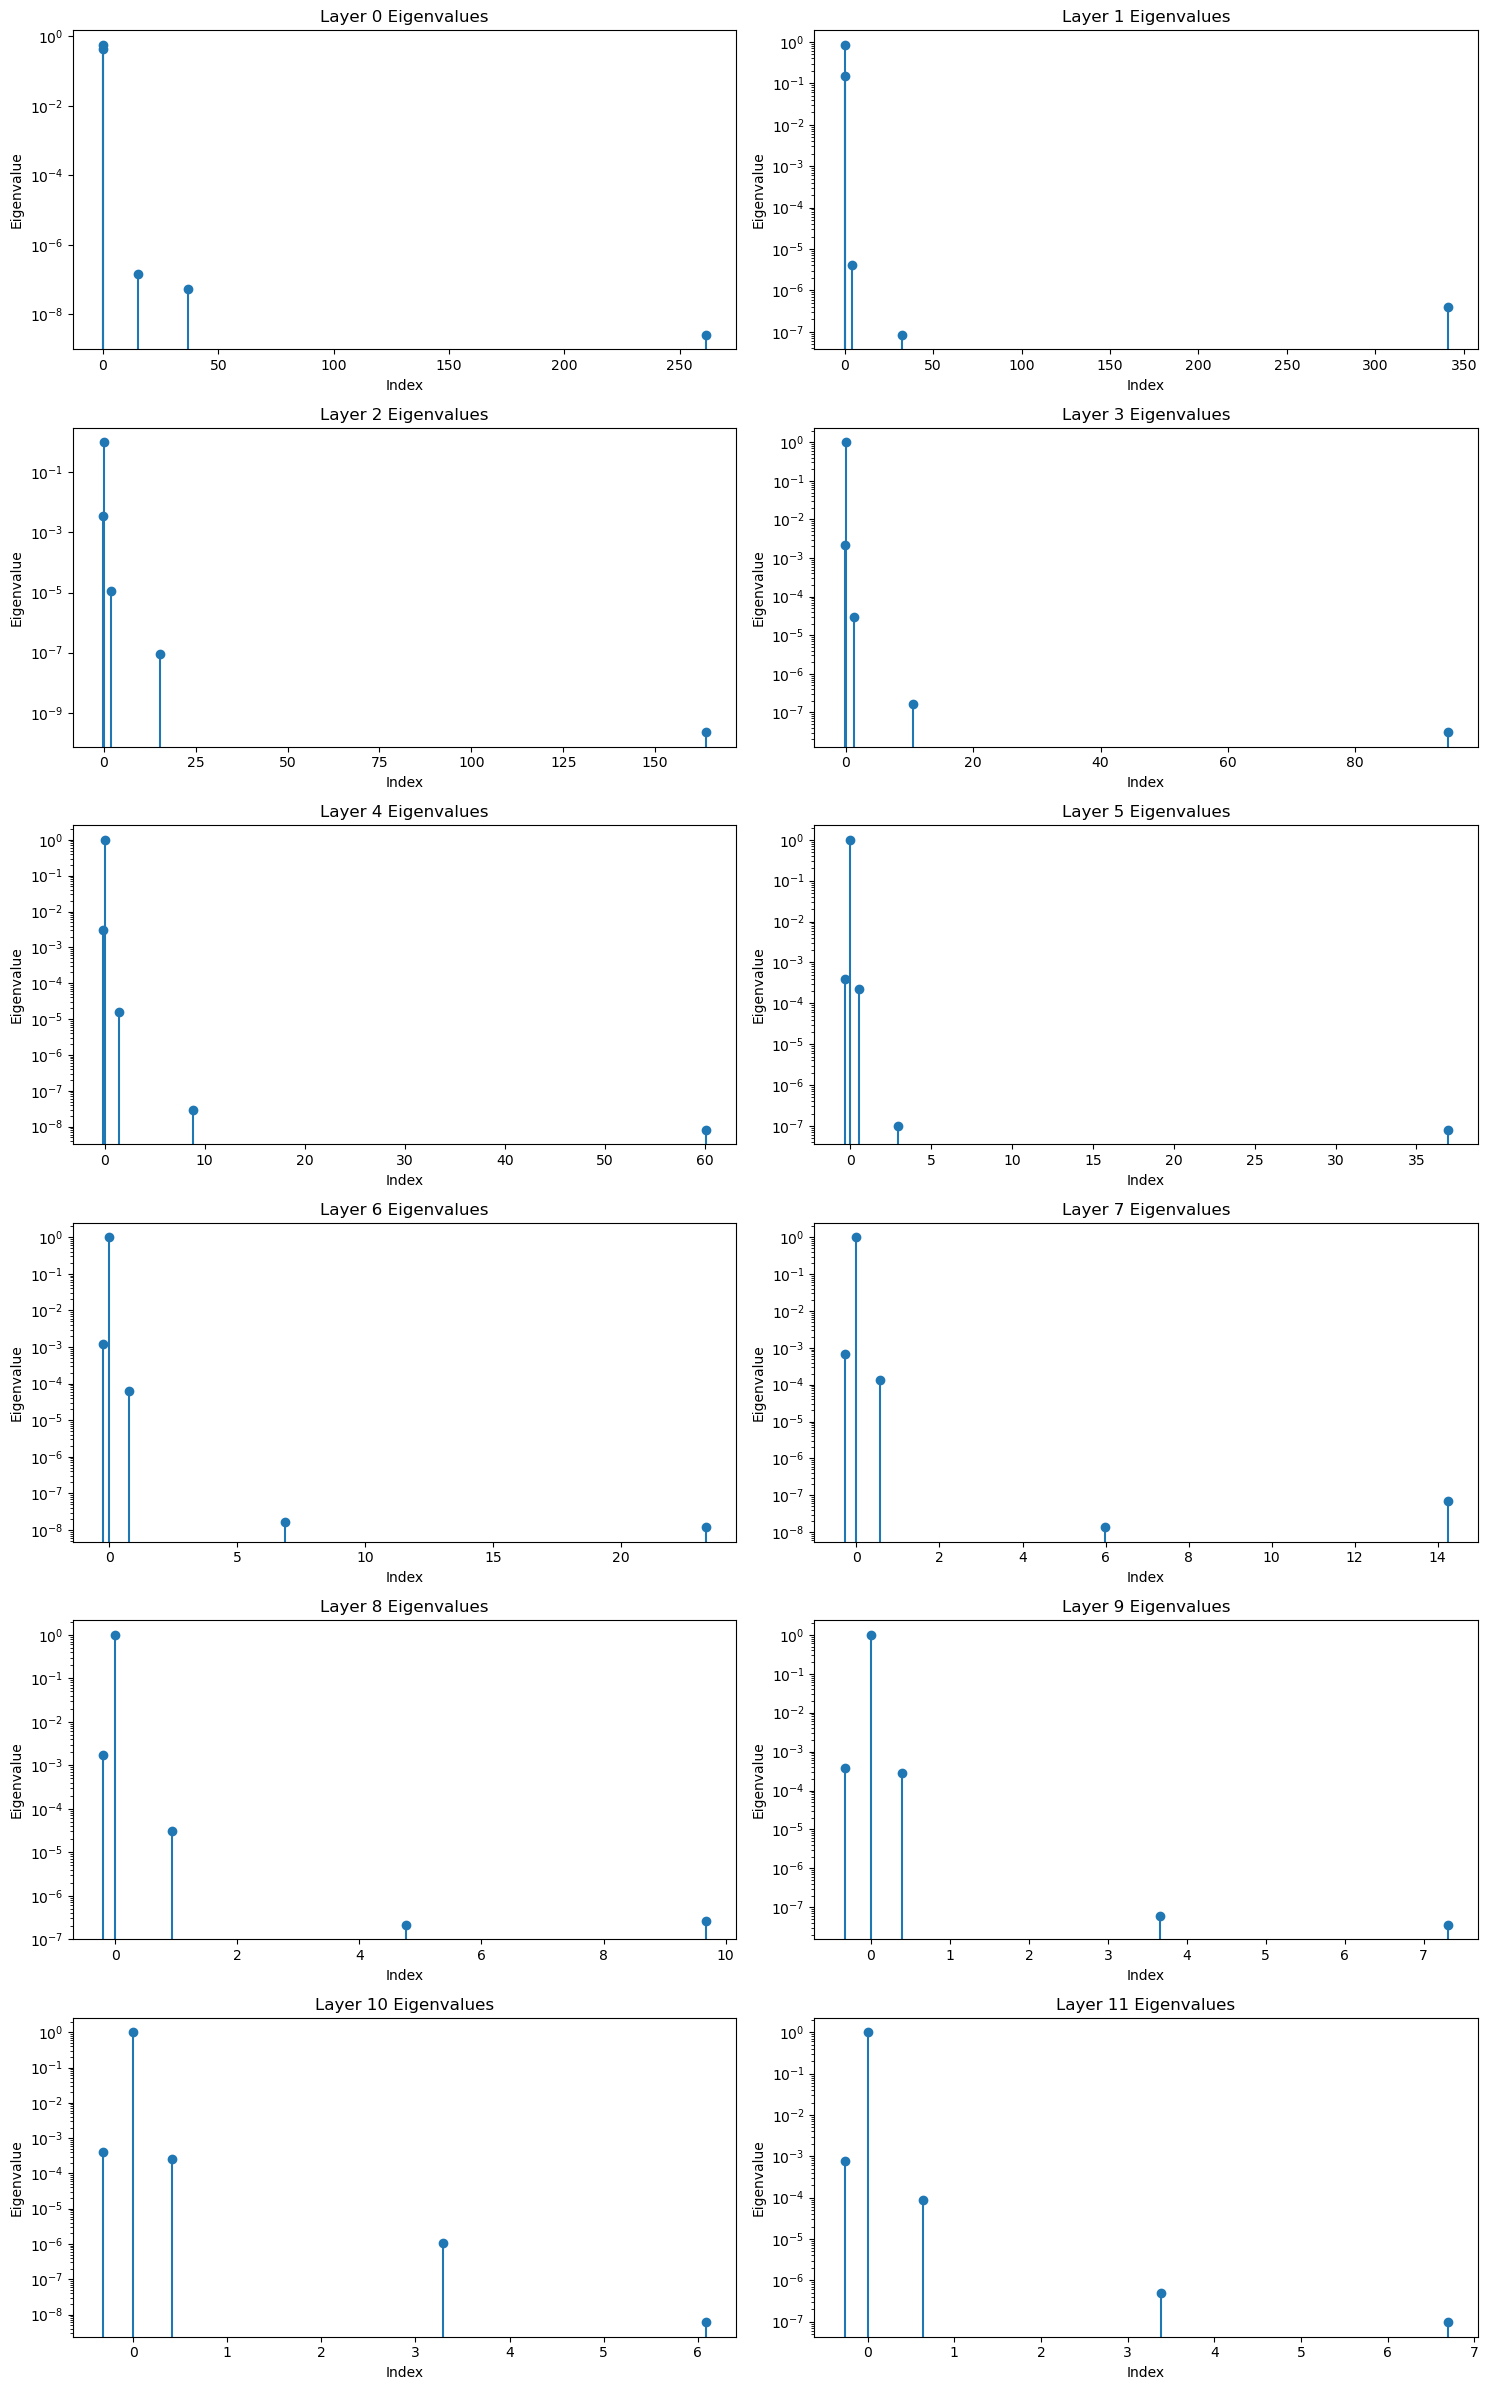

In [45]:
num_layers = len(model.transformer.h)

fig, axes = plt.subplots(nrows=num_layers//2, ncols=2, figsize=(15, num_layers*2))
axes = axes.flatten()

for i, layer in enumerate(model.transformer.h):
    ax = axes[i]
    ax.set_yscale('log')

    eigvals = all_eigvals[i]
    gammas = all_gammas[i].cpu().detach().numpy()
    ax.stem(eigvals, gammas)
    ax.set_title(f'Layer {i} Eigenvalues')

    ax.set_xlabel('Index')
    ax.set_ylabel('Eigenvalue')

plt.tight_layout()
plt.show()
